Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Train Acc: 50.32%, Val Acc: 61.09%, Train Loss: 1.4063, Val Loss: 1.0816
Epoch [2/50], Train Acc: 67.33%, Val Acc: 70.98%, Train Loss: 0.9237, Val Loss: 0.8446
Epoch [3/50], Train Acc: 73.42%, Val Acc: 74.39%, Train Loss: 0.7571, Val Loss: 0.7239
Epoch [4/50], Train Acc: 76.71%, Val Acc: 76.00%, Train Loss: 0.6641, Val Loss: 0.6904
Epoch [5/50], Train Acc: 79.19%, Val Acc: 77.82%, Train Loss: 0.5990, Val Loss: 0.6502
Epoch [6/50], Train Acc: 80.93%, Val Acc: 80.11%, Train Loss: 0.5421, Val Loss: 0.5762
Epoch [7/50], Train Acc: 82.65%, Val Acc: 80.96%, Train Loss: 0.5010, Val Loss: 0.5557
Epoch [8/50], Train Acc: 83.54%, Val Acc: 81.88%, Train Loss: 0.4656, Val Loss: 0.5111
Epoch [9/50], Train Acc: 84.86%, Val Acc: 83.57%, Train Loss: 0.4367, Val Loss: 0.4807
Epoch [10/50], Train Acc: 85.94%, Val Acc: 81.96%, Train Loss: 0.4064, Val Loss: 0.5487
Epoch [11/50], Train Acc: 87.02%, Val Acc: 83.74%, Tr

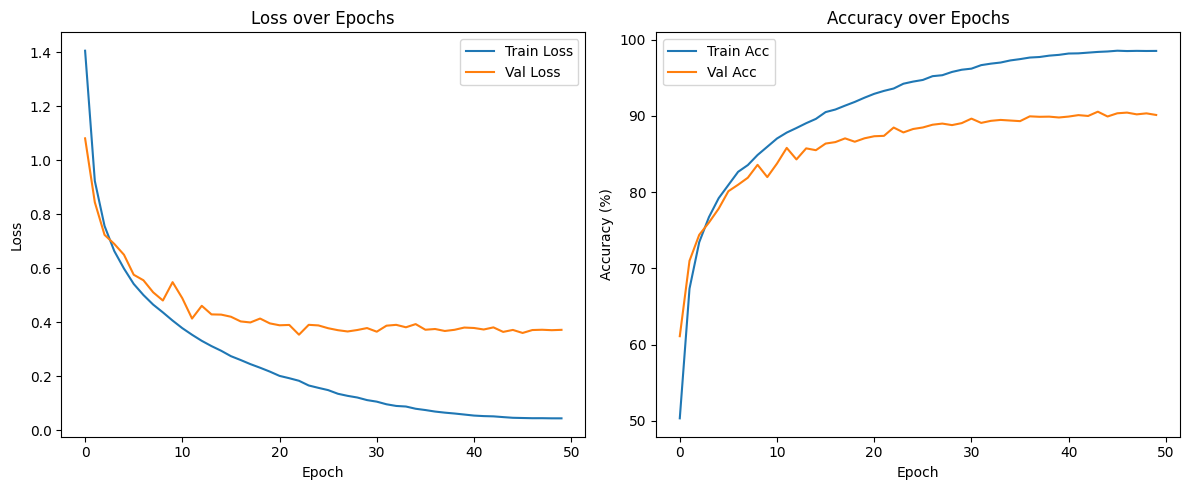

Training completed in 1486.60 seconds.


: 

In [ ]:
# CIFAR-10 Training with 9-Layer CNN and Custom Initializations (Optimized)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 128
learning_rate = 0.001

# CIFAR-10 dataset with augmentation
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Custom weight initialization (He shallow + Orthogonal deep with gain)
def custom_init(model):
    relu_gain = nn.init.calculate_gain('relu')
    layer_idx = 0
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if layer_idx < 6:  # Apply He init to early layers
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            else:  # Orthogonal to deeper layers with gain
                nn.init.orthogonal_(m.weight, gain=relu_gain)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
            layer_idx += 1

# 9-Layer CNN Model
class OptimalCNN(nn.Module):
    def __init__(self):
        super(OptimalCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# Training function with LR scheduler
def train_model(model):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss / len(train_loader))

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss / len(test_loader))

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}")

    duration = time.time() - start_time
    return train_acc_list, val_acc_list, train_loss_list, val_loss_list, duration

# Main experiment
model = OptimalCNN()
custom_init(model)  # Hybrid initialization with gain
train_acc, val_acc, train_loss, val_loss, time_taken = train_model(model)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Training completed in {time_taken:.2f} seconds.")
